# Recommendations with IBM

In this notebook, I will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 

By following the table of contents, I will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

Let's get started by importing the necessary libraries and reading in the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

I will be using the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` I can show the distribution of how many articles a user interacts with in the dataset. I can show this by providing a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [70]:
# Looking at which column identifies the user interaction with the articles
for i in np.arange(3):
    print(df.columns[i], df[df.columns[i]].nunique())

article_id 714
title 714
user_id 5149


In [71]:
df.shape

(45993, 3)

From our unique values it is inferred that the email column indetifies user interactions. From the size of our dataset (45993,3) we can see is comprised of  714 articles with interactions by 5148 users.

In [72]:
df.email.value_counts().describe()

AttributeError: 'DataFrame' object has no attribute 'email'

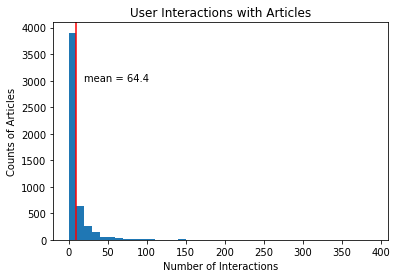

In [7]:
# Distribution of user interactions with articles
plt.hist(df.email.value_counts(), bins = np.arange(0,400,10))
plt.axvline(df.email.value_counts().mean(), color='r')
plt.text(20, 3000,'mean = 64.4',rotation=0)
plt.xlabel('Number of Interactions')
plt.ylabel('Counts of Articles')
plt.title('User Interactions with Articles');

In [8]:
median_val = df.email.value_counts().median()
max_views_by_user = df.email.value_counts().max()
print('The median value of user interactions is {} and the max user interactions is {}'.format(median_val, max_views_by_user))

The median value of user interactions is 3.0 and the max user interactions is 364


`2.` Exploring and removing duplicate articles from the **df_content** dataframe.  

In [9]:
# Looking at duplicates in each column
for i in np.arange(5):
    print(df_content.columns[i], df_content[df_content.columns[i]].duplicated().sum())

doc_body 19
doc_description 33
doc_full_name 5
doc_status 1055
article_id 5


From our duplicated values we can see that there are only 5 duplicated articles. Although, the document body is duplicated 19 times we will not remove these because they've had interactions with users. We will need to remove duplicated articles to continue our analysis.

In [10]:
# Removing rows that have the same article_id while only keeping the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first')
# Confirming the duplicates were removed
df_content.article_id.duplicated().sum()

0

`3.` Using the cells below I can find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
# a. The number of unique articles that have an interaction with a user
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
# b. The number of unique articles in the dataset (whether they have any interactions or not)
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
# c. The number of unique users in the dataset. (excluding null values)
unique_users = df.email.nunique() # The number of unique users
# d. The number of user-article interactions in the dataset
user_article_interactions = df.article_id.count() # The number of user-article interactions

`4.` Using the cells below we can find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df.article_id.value_counts().index[0]) 
# The most number of views for the most viewed article in the dataset
max_views = df.article_id.value_counts().max()  

In [13]:
# Maps the user email to a user_id column and removes the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [14]:
# Testing my solutions against known values

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Testing my dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Filling in the function below to return the **n** top articles ordered with most interactions as the top. I can test my function using the tests below.

In [15]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids
    
    '''
    
    top_article_ids = df.article_id.value_counts().index[:n].tolist()
 
    return top_article_ids 


def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_article_titles = []
    top_article_ids = df.article_id.value_counts().index[:n]
    
    for i in np.arange(n):
        article = df.title[df.article_id == top_article_ids[i]].iloc[0]
        top_article_titles.append(article)
 
    return top_article_titles

In [16]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [17]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Using the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

I can use the tests to make sure the basic structure of my matrix matches what is expected by the solution.

In [18]:
def create_user_item_matrix(df=df, row='user_id', col='article_id'):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    val_row_id = sorted(np.array(df[row].drop_duplicates()))
    val_col_id = sorted(np.array(df[col].drop_duplicates()))
    user_item_zeros = np.zeros((len(val_row_id), len(val_col_id)))
    user_item_zeros = pd.DataFrame(data = user_item_zeros, index = val_row_id, columns = val_col_id)

    row_id_1d = np.array(df[row])
    col_id_1d = np.array(df[col])
    user_inter = np.vstack((row_id_1d, col_id_1d)).T

    for m,n in user_inter:
        user_item_zeros.loc[m,n]=1
        
    user_item = user_item_zeros

    return user_item

user_item = create_user_item_matrix()
user_item

,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Testing user item matrix
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [20]:
# Every user in this database has made atleast one interaction with an article
(user_item.sum(axis = 0) == 0).sum()

0

`2.` Completing the function below will take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it makes sense to compute similarity as the dot product of two users. 

I can use the tests to test my function.

In [21]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Computing similarity of each user to the provided user
    user_sim = user_item[user_item.index == user_id].dot(user_item.T)

    # Sorting by similarity
    most_similar_users = user_sim.sort_values(user_id, axis=1, ascending=False).columns.tolist()
   
    # Removing the own user's id
    most_similar_users.remove(user_id)
    
    # Returns a list of the users in order from most to least similar
    return most_similar_users 

In [22]:
# Doing a spot check of find_similar_users function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that I have a function that provides the most similar users to each user, we will want to use these users to find articles you can recommend.  Completing the functions below will return the articles you would recommend to each user. 

In [23]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    # Finding article names
    article_names = []
    
    for idx in article_ids:
        article_names.append(df[df['article_id'] == float(idx)]['title'].drop_duplicates().tolist()[0])

    return article_names 

In [24]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    # Finding article ids
    article_ids = []
    
    for idx in user_item.loc[user_id][user_item.loc[user_id] == 1].index.tolist():
        article_ids.append(str(idx))
        
    article_names = get_article_names(article_ids)
    
    # Returns article_ids and article_names that have been seen by a user
    return article_ids, article_names 
    

In [25]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # Every user has made an interaction with an article, we will need at most 'm' users
    sim_users = find_similar_users(user_id)
    
    # Primary user's article_ids and article_names
    p_article_ids, p_article_names = get_user_articles(user_id)
    
    # Recommendations
    recs = []
    
    # If there are enough recommendations of similiar users this loop fills the recommendations
    for user in sim_users:
        article_ids, article_names = get_user_articles(user)
        
        for idx in article_ids:
            if idx not in p_article_ids:
                recs.append(idx)
            if len(recs) >= m:
                break
        if len(recs) >= m:
            break
            
    # If there are not enough recommendations from similiar users this statement fills the recommendations
    if len(recs) < m:
        for idx in get_top_articles(df.article_id.nunique()):
            if idx not in p_article_ids:
                recs.append(idx)
            if len(recs) >= m:
                break 
    
    # Return recommendations for this user_id   
    return recs 

In [26]:
# Returning 10 recommendations for user 1
get_article_names(user_user_recs(1, 10)) 

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [27]:
# Testing functions here 
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")


If this is all you see, you passed all of our tests!  Nice job!


`4.` Now I'm going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - we can choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we can choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function I wrote earlier.

In [28]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbours_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u             
    Other Details - neighbors_df is sorted by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # Creating dataframe
    neighbours_df = pd.DataFrame(columns=['neighbour_id', 'similarity', 'num_interactions'])
    
    # Iterating for every user in data to compare to user_id entered in function
    for user in user_item.index:
        
        # Filling dataframe with values for every user and ordering them by user_id
        neighbours_df.loc[user] = [user, # User id
                                  np.dot(user_item.loc[user_id, :], user_item.loc[user, :]), # Similarity dop product
                                  df[df['user_id']==user]['article_id'].count()] # Interaction count for user
    
    # Reordering values by similarity and num_interactions which will be useful in my next function
    neighbours_df.sort_values(by = ['similarity', 'num_interactions'], ascending = False, inplace = True)
    neighbours_df.drop(neighbours_df.head(1).index, inplace=True)

    # Return the dataframe specified in the doc_string
    return neighbours_df 

In [29]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Chose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Chose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    # Created a ranked dataframe of articles
    t_articles = get_top_articles(df.article_id.nunique())
    top_articles = pd.DataFrame(columns = ['article_names','rank'])
    for i in np.arange(len(t_articles)):
        top_articles.loc[i] = [t_articles[i], np.arange(len(t_articles))[i]]
    
    # Primary user's article_ids and article_names
    p_article_ids, p_article_names = get_user_articles(user_id)
    
    # Getting dataframe of similiarity and num_interactions for similiar users to user_id enetered in function
    top_sorted_users = get_top_sorted_users(user_id)
    
    # List of neighbour ids
    neighbour_ids = top_sorted_users['neighbour_id'].tolist()
    
    # Recommendations
    recs = []
    
    # loops through all neighbour ids in order of similarity
    for user in neighbour_ids:
        
        # Creating a dataframe of the neighbour's articles and organizes them based on rankings
        article_ids, article_names = get_user_articles(user)
        temp_df = pd.DataFrame(columns = ['article_ids','article_names'])
        
        for i in np.arange(len(article_ids)):
            temp_df.loc[i] = [article_ids[i], article_names[i]]

        temp_df = temp_df.merge(top_articles, how = 'left', on='article_names')
        temp_df.sort_values(by = 'rank', ascending = True, inplace = True)
        
        ranked_article_ids = temp_df['article_ids'].tolist()
        
        # Checks ranked list and fills recommendations from highest ranked to lowest with the highest degree
        # of similarity, if there are enough recommendations this loop fills the recommendations
        for idx in ranked_article_ids:
            if idx not in p_article_ids:
                recs.append(idx)
            if len(recs) >= m:
                break
        if len(recs) >= m:
                break
     
    # If there are not enough recommendations from similiar users this statement fills the recommendations
    if len(recs) < m:
        for idx in get_top_articles(df_content.article_id.nunique()):
            if idx not in p_article_ids:
                recs.append(idx)
            if len(recs) >= m:
                break 
    
    # retrieving article names from recommendations
    rec_names = get_article_names(recs)
    
    # Returning recommendations with ids, and names
    return recs, rec_names

In [30]:
# Quick spot check 
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Using my functions from above to correctly fill in the solutions to the dictionary below, I can then test my dictionary against the solution.

In [31]:
### Tests with a dictionary of results
df_user1_most_sim = get_top_sorted_users(1)
user1_most_sim = df_user1_most_sim['neighbour_id'].tolist()[0]
print(user1_most_sim)
df_user131_10th_sim = get_top_sorted_users(131)
user131_10th_sim = df_user131_10th_sim['neighbour_id'].tolist()[9]
print(user131_10th_sim)

3933.0
242.0


In [32]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, how would I be able to make recommendations?  

The function get_top_users would recommend the most popular or interacted with articles. Without any information on a new user that is the best we could recommend. The function user_user_recs_part2 uses get_top_users to provide any recommendations that weren't fulfilled by similiar users.

`7.` Using my existing functions, I can provide the top 10 recommended articles for the a new user below. I can test my function against known solutions we know how we might make a recommendation.

In [33]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(id) for id in get_top_article_ids(10)]



In [34]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, I will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` I have already created a **user_item** matrix in **question 1** of **Part III** above. I will run the cells to get things set up for the rest of **Part V** of the notebook. 

In [35]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [36]:
# Quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, we can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix. The matrix has no Nan values or missing enteries and this permits the use of SVD even on this sparse matrix.

In [37]:
# Performing SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix, and the accuracy improves as we increase the number of latent features.

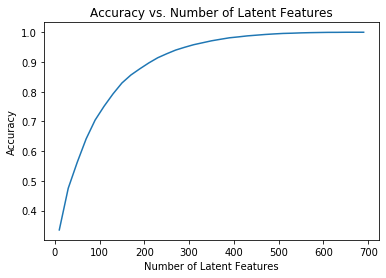

In [38]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # Restructuring with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # Taking dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # Computing error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # Total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we should split our dataset into a training and test set of data, as shown in the cell below.  

We should also understand the following: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [39]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df=df_train, row='user_id', col='article_id')
    
    user_item_test = create_user_item_matrix(df=df_test, row='user_id', col='article_id')
    
    test_idx = user_item_test.index.values
    
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [40]:
user_item_train.shape, user_item_test.shape, len(test_idx), len(test_arts)

((4487, 714), (682, 574), 682, 574)

In [41]:
user_item_train.index.isin(test_idx).sum()

20

In [42]:
user_item_train.columns.isin(test_arts).sum()

574

In [43]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now I will use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that I can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

I will use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

I will be performing Singular Value Decomposition on, we're going to do just that. To get started, let's remind ourselves about the dimensions of each of the matrices we are going to get back. Essentially, we are going to split the **user_item_matrix** matrix into five matrices and use:

$$ U \Sigma V^T $$


In [44]:
# Performing SVD
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [69]:
# Restructuring to get the U test matrix
test_idx = user_item_test.index.values
row_test_idx = user_item_train.index.isin(test_idx)
u_test = u_train[row_test_idx, :]
u_test.shape

U matrix shape is (20, 4487)


In [63]:
# Restructuring to get the V^T test matrix
test_col = user_item_test.columns
col_test_idx = user_item_train.columns.isin(test_col)
vt_test = vt_train[:, col_test_idx]
vt_test.shape

(714, 574)

In [64]:
# Restructuring to get the user_item test subset matrix we need to validate predictions 
train_idx = user_item_train.index
row_train_idx = user_item_test.index.isin(train_idx)
user_item_test_sub = user_item_test.loc[row_train_idx]
user_item_test_sub.shape

(20, 574)

Our matrices are of correct sizes to make predictions, we will need to resize these propotionately to the latent features to make predictions. I will do this below:

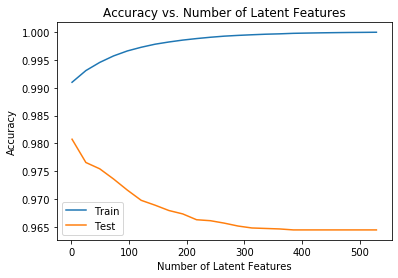

In [73]:
from sklearn.metrics import accuracy_score

# Initilazing lists, latent features and SVD matrices
t_errors, train_errors, test_errors = [], [], []
lat_feat = np.arange(1, vt_test.shape[1], vt_test.shape[1]/23, dtype=np.int16)
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

for l in lat_feat:
    
    # Matrices
    lat_feat_u_train = u_train[:, :l]
    lat_feat_s_train = np.diag(s_train[:l])
    lat_feat_vt_train = vt_train[:l, :]
    lat_feat_u_test = u_test[:, :l]
    lat_feat_vt_test = vt_test[:l, :]    
    
    # Predictions
    user_item_train_preds = np.around(np.dot(np.dot(lat_feat_u_train, lat_feat_s_train), lat_feat_vt_train))
    user_item_test_preds = np.around(np.dot(np.dot(lat_feat_u_test, lat_feat_s_train), lat_feat_vt_test))
    
    # Errors
    train_errors.append(accuracy_score(user_item_train.values.flatten(), user_item_train_preds.flatten()))
    test_errors.append(accuracy_score(user_item_test_sub.values.flatten(), user_item_test_preds.flatten()))

# Plotting
plt.figure()
plt.plot(lat_feat, train_errors, label='Train')
plt.plot(lat_feat, test_errors, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

`6.` The cell below comments on the results I found in the previous question. Given the circumstances of my results,  I will discuss what I might do to determine if the recommendations I make with any of the above recommendation systems are an improvement to how users currently find articles. 

The more latent features we train our algorithm on, the lower accuracy score we get on our testing set. This is evidence of overfitting. Due to the low number of users we are able to test our predictions on its not surprising that we see evidence of overfitting. Matrix factorization is only one way of making recommendations. Among other algorithms are knowledge based and content based filtering. There are also several other collaborative filtering algorithms we could explore.

The problem with creating recommendations for a new user is know as the cold start problem. A new user doesnt have any interactions yet for us to use similiar users and create predictions. A knowledge based recommendation engine would not rely on user information and could select articles based on parameters they define.

<a id='conclusions'></a>
## Conclusion

We saw the algorithm I made could get correct predictions with an accuracy between 96-98% approximately. Combining this recommendation engine with knowledge on content based recommendastions could give users a better experience finding more relevant content.<br>

We could improve our model by considering:
> How many latent features leads to the best accuracy? <br>
> How many users are in our test set and is this enough to make predictions for the entire user base? <br>
> How can we add other recommendation methods to improve our model <br>

I explored many of these questions and if we wanted to make a production model we could act on our insights uncovered in this project.





In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])